<a href="https://colab.research.google.com/github/lszam/plates/blob/main/expansao_de_grid_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.interpolate import griddata

#Função
def GradHoriz(vetor, nx, ny, dx, dy):
  dx2 = 2*dx
  dy2 = 2*dy
  vetor_GH = np.ones(nx*ny)
  for j in range(1, ny+1):
    jm1 = j - 1
    if jm1 < 1: #condição de borda
      jm1 = 1
    jp1 = j + 1
    if jp1 > ny: #condição de borda
      jp1 = ny
    for i in range(1, nx+1):
      im1 = i - 1
      if im1 < 1: #condição de borda
        im1 = 1
      ip1 = i + 1
      if ip1 > nx: #condição de borda
        ip1 = nx
      #index(i,j,nx) = (j-1) * nx + i #função index em Blakely (1996)
      indexip1 = (jp1-1) * nx + (i-1)
      indexim1 = (j-1) * nx + (im1-1)
      indexjp1 = (jp1-1) * nx + (i-1)
      indexjm1 = (j-2) * nx + (i-1)
      #Análise de valores no espaço
      dfdx = (vetor[indexip1]-vetor[indexim1]) / dx2
      dfdy = (vetor[indexjp1]-vetor[indexjm1]) / dy2
      ij = (j-1) * nx + (i-1)
      vetor_GH[ij] = np.sqrt(dfdx**2+dfdy**2)

  #As linhas a seguir são ativada se for preciso retornar um grid
  #grid_GH = np.reshape(vetor_GH, (ny, nx))
  #return grid_GH

  return vetor_GH

df_S1 = pd.read_csv('map1_python_realxy.csv')
df_S1

,Unnamed: 0,PROFILE,X,Y,Z,S
0,2301,AY,-6487.507399,-3517.382988,-560.609149,1.0
1,2290,AX,-6402.413424,-3517.265341,-565.368797,1.0
2,2289,AX,-6416.255376,-3506.692189,-507.614065,1.0
3,1133,AV,-6253.640288,-3504.445250,-550.692515,1.0
4,1152,AW,-6336.833676,-3504.439326,-561.058966,1.0
...,...,...,...,...,...,...
1213,1175,C,-5897.729012,-1734.937904,-372.616756,1.0
1214,1216,D,-5760.401755,-1731.475563,-381.978977,1.0
1215,1176,C,-5879.643841,-1728.309077,-341.750057,1.0
1216,1177,C,-5852.254572,-1718.269982,-341.776770,1.0


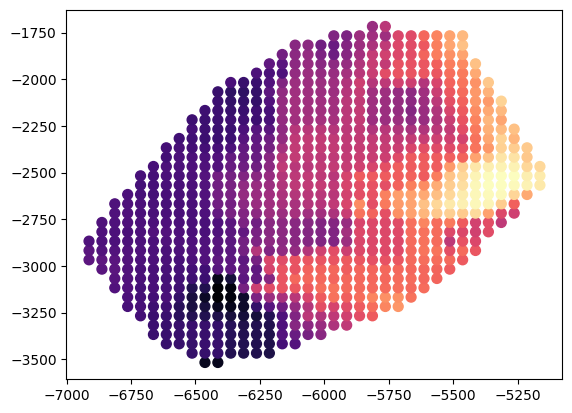

In [5]:
# OBTER X Y Z E CRIAR GRID REGULAR COM POSIÇÕES INTEIRAS
# Opção escolhida para facilitar os testes da expansão

#tratamento para criar um grid com células de tamanho inteiro
cell=int(50)

X = df_S1['X'].values
Y = df_S1['Y'].values
Z = df_S1['Z'].values
X_new, new_xcoord = [np.ceil(min(X))], np.ceil(min(X))
Y_new, new_ycoord = [np.ceil(min(Y))], np.ceil(min(Y))
for xcoord in X:
  while new_xcoord < xcoord:
    new_xcoord = new_xcoord + cell
    X_new.append(new_xcoord)
for ycoord in Y:
  while new_ycoord < ycoord:
    new_ycoord = new_ycoord + cell
    Y_new.append(new_ycoord)
xi, yi = np.meshgrid(X_new, Y_new)
zi = griddata((X, Y), Z, (xi, yi), method='linear')
plt.scatter(xi, yi, c=zi, s=cell, cmap='magma')

Old size: 38 38 New: 76.0 76.0
New itens at horizontal and vertical sides: 19.0 19.0


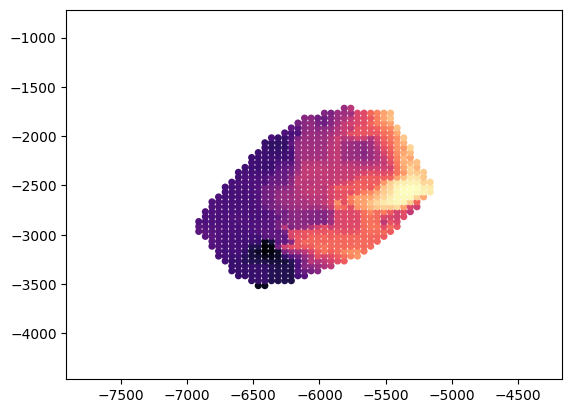

In [28]:
#EXPANDIR A GRADE

#PARAMETRO
expansion_factor = 2

# Calcular o novo tamanho do grid
n_x = np.shape(xi)[1]
n_y = np.shape(yi)[0]
n_xborder = np.ceil(((xi.shape[0] * expansion_factor) - xi.shape[0]) / 2)
n_yborder = np.ceil(((yi.shape[1] * expansion_factor) - yi.shape[0]) / 2)
new_size_x = np.shape(xi)[1] + n_xborder*2
new_size_y = np.shape(yi)[0] + n_yborder*2
print("Old size:", n_x, n_y, "New:", new_size_x, new_size_y)
print("New itens at horizontal and vertical sides:", n_xborder, n_yborder) #por hora este valor precisa ser numero inteiro
# Localizar os índices de x e y mínimos e máximos
indice_min_x = np.unravel_index(np.argmin(xi), xi.shape)
indice_min_y = np.unravel_index(np.argmin(yi), yi.shape)
indice_max_x = np.unravel_index(np.argmax(xi), xi.shape)
indice_max_y = np.unravel_index(np.argmax(yi), yi.shape)
# Calcular os novos x e y mínimos
new_xi_min = xi.min() - (n_xborder * cell)
new_yi_min = yi.min() - (n_yborder * cell)
new_xi_max = xi.max() + (n_xborder * cell)
new_yi_max = yi.max() + (n_yborder * cell)
# Criar uma nova grade expandida para X e Y
x_expanded = np.linspace(new_xi_min, new_xi_max, int(new_size_x))
y_expanded = np.linspace(new_yi_min, new_yi_max, int(new_size_y))
xi_exp, yi_exp = np.meshgrid(x_expanded, y_expanded)
zi_exp = np.empty((np.shape(xi_exp)[1], np.shape(yi_exp)[0]))
zi_exp[:] = np.nan
# Criar uma máscara booleana onde zi não é NaN
mask_nan = np.isnan(zi)
# Encontrar os índices onde zi não é nulo (não é NaN)
valid_values_indexes = np.where(~mask_nan)
# valid_values_indexes é uma tupla de dois arrays
#valid_values_lin, valid_values_col = valid_values_indexes
for valid_l in valid_values_indexes[0]:
  for valid_c in valid_values_indexes[1]:
    # encontrar o valor real de x e y da nova posicao (no grid expandido)
    x_, y_ = xi[valid_l, valid_c], yi[valid_l, valid_c]
    # encontrar o indice da nova posicao em zi_exp (grid zi expandido)
    new_coord = np.where(np.logical_and(xi_exp == x_, yi_exp==y_))
    zi_exp[new_coord[0][0]][new_coord[1][0]] = zi[valid_l, valid_c]

plt.scatter(xi_exp, yi_exp, c=zi_exp, cmap='magma', s=cell/3)
plt.xlim(np.min(xi_exp),np.max(xi_exp))
plt.ylim(np.min(yi_exp),np.max(yi_exp))
plt.show()

####Preenchimento #1

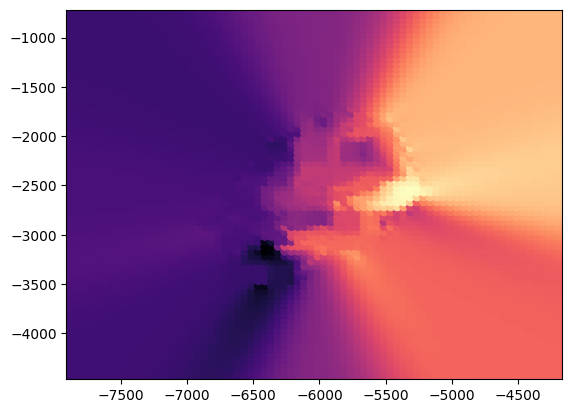

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# PARAMETROS
window_width = 1

# Criar uma cópia de zi_exp
zi_exp_smooth = zi_exp.copy()

# Encontrar índices dos pontos NaN
nan_indices = np.argwhere(np.isnan(zi_exp))

# Calcular o centro do grid
center_x = new_size_x // 2
center_y = new_size_y // 2

# Criar uma função para calcular a distância do centro
def distance_to_center(i, j):
    return np.sqrt((i - center_x) ** 2 + (j - center_y) ** 2)

# Ordenar os índices NaN com base na distância ao centro
nan_indices = sorted(nan_indices, key=lambda idx: distance_to_center(idx[0], idx[1]))

# Aplicar suavização local em cada ponto NaN, do centro para as bordas
for i, j in nan_indices:
    # Definir os índices da janela de vizinhança em torno do ponto NaN
    window_x_min = max(0, i - window_width)
    window_x_max = min(new_size_x, i + window_width + 1)
    window_y_min = max(0, j - window_width)
    window_y_max = min(new_size_y, j + window_width + 1)
    # Extrair a janela de vizinhança da matriz zi_exp_smooth
    neighborhood = zi_exp_smooth[int(window_x_min):int(window_x_max), int(window_y_min):int(window_y_max)]
    # Calcular a média de valores válidos na vizinhança
    valid_values = neighborhood[~np.isnan(neighborhood)]
    if len(valid_values) > 0:
        zi_exp_smooth[i, j] = np.mean(valid_values)
        #zi_exp_smooth[i, j] = np.median(valid_values)

plt.scatter(xi_exp, yi_exp, c=zi_exp_smooth, cmap='magma', s=30)
plt.xlim(np.min(xi_exp), np.max(xi_exp))
plt.ylim(np.min(yi_exp), np.max(yi_exp))
plt.show()


####GHT com expansão

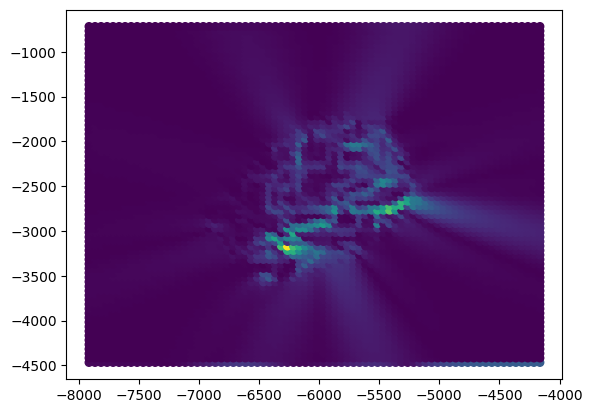

In [35]:
#GHT com a expansão
vetor_X = xi_exp.flatten()
vetor_Y = yi_exp.flatten()
vetor_Z = zi_exp_smooth.flatten()
pontos_X=[]
pontos_Y=[]
[pontos_X.append(item) for item in vetor_X if not pontos_X.count(item)]
[pontos_Y.append(item) for item in vetor_Y if not pontos_Y.count(item)]
#Número de itens a leste e a norte
nx = np.size(pontos_X)
ny = np.size(pontos_Y)
#Distancia entre pontos em x e y
dx, dy = np.abs(pontos_X[0]-pontos_X[1]), np.abs(pontos_Y[0]-pontos_Y[1])
vetor_Z = np.nan_to_num(vetor_Z, nan=0) # Substituir NaN por 0
vetor_GH = GradHoriz(vetor_Z, nx, ny, dx, dy)
df_S1_new = pd.DataFrame({'X': vetor_X, 'Y': vetor_Y, 'Z': vetor_Z, 'GHT': vetor_GH})
plt.scatter(df_S1_new['X'],df_S1_new['Y'],c=df_S1_new['GHT'], s=30)